In [1]:
import tensorflow as tf

In [2]:
my_model = tf.keras.models.load_model("./IAI_IMS_pretrained_model_final.h5")

In [3]:
import glob

In [4]:
files_normal = glob.glob("D:/matlab/ims/normal/*")
files_inner = glob.glob("D:/matlab/ims/inner/*")
files_outer = glob.glob("D:/matlab/ims/outer/*")
files_ball = glob.glob("D:/matlab/ims/ball/*")

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
_, train_normal = train_test_split(files_normal, test_size = 50, random_state = 23)
_, train_inner = train_test_split(files_inner, test_size = 50, random_state = 34)
_, train_outer = train_test_split(files_outer, test_size = 50, random_state = 232)
_, train_ball = train_test_split(files_ball, test_size = 50, random_state = 12)

In [7]:
train_files = train_normal + train_inner + train_outer + train_ball
len(train_files)

200

In [8]:
test_files = files_normal[650:750] + files_inner[650:750] + files_outer[650:750] + files_ball[650:750]
len(test_files)

400

In [9]:
import pandas as pd
import numpy as np
import re

In [10]:
def create_data(file_names):
    data = []
    labels = []
    patterns = tf.constant([".*(normal)", ".*(inner)", ".*(outer)", ".*(ball)"])
    for file in file_names:
        temp = pd.read_csv(open(file,'r'), sep = "\s+", header = None)
        fault_columns = [0, 4, 2, 6]              # In this order, 0-normal, 4-inner, 2-outer, 6-ball
        num = np.int(np.floor(len(temp[0])/1024)) # As all columns have same number of entries
        j = 0
        for pattern in patterns:
            if re.match(pattern.numpy(), tf.constant(file).numpy()):
                labels = labels + list(np.repeat(j,num)) 
                column_number = fault_columns[j]
                break
            j = j + 1   
        data = data + list(temp[column_number][0:num*1024].values.reshape(num,32,32,1))

    data = np.asarray(data).reshape(-1,32,32,1)
    labels = np.asarray(labels)
    return data, labels  

In [11]:
train_data, train_labels = create_data(train_files)
print(train_data.shape, train_labels.shape)

(4000, 32, 32, 1) (4000,)


In [12]:
test_data, test_labels = create_data(test_files)
print(test_data.shape, test_labels.shape)

(8000, 32, 32, 1) (8000,)


In [13]:
my_model.pop()

In [14]:
outputs_train = my_model(train_data)
outputs_train = outputs_train.numpy()
outputs_train.shape

(4000, 16)

In [15]:
outputs_test = my_model(test_data)
outputs_test = outputs_test.numpy()
outputs_test.shape

(8000, 16)

In [16]:
index = np.random.permutation(len(outputs_train))

In [17]:
outputs_train, train_labels = outputs_train[index], train_labels[index]

In [18]:
from sklearn.svm import SVC

In [19]:
svm_fit = SVC(C = 1, kernel = "rbf", gamma = 0.01)

In [20]:
svm_fit.fit(outputs_train, train_labels)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
train_res = svm_fit.predict(outputs_train)

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
confusion_matrix(train_labels, train_res)

array([[1000,    0,    0,    0],
       [   0, 1000,    0,    0],
       [   0,    0, 1000,    0],
       [   1,    0,    0,  999]], dtype=int64)

In [24]:
test_res = svm_fit.predict(outputs_test)

In [25]:
mat = confusion_matrix(test_labels, test_res)
mat

array([[1998,    0,    0,    2],
       [   0, 1998,    2,    0],
       [   0,    0, 2000,    0],
       [   0,    1,    0, 1999]], dtype=int64)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

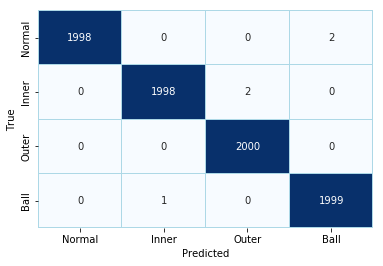

In [27]:
confu = sns.heatmap(mat, cmap = "Blues",annot = True, fmt = "d", cbar = False,
                    xticklabels = ["Normal", "Inner", "Outer", "Ball"],
                    yticklabels = ["Normal", "Inner", "Outer", "Ball"],
                    linewidths = 0.1, linecolor = "lightblue")
confu.set(xlabel = "Predicted", ylabel = "True")
confu.set_yticklabels(confu.get_yticklabels(),va = "center", rotation = 90)
plt.savefig("confusion_matrix_ims_iai.png", bbox_inches = "tight")

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
accuracy_score(test_labels, test_res)

0.999375

In [30]:
from sklearn.manifold import TSNE

In [31]:
fault_type = pd.Categorical(np.repeat(["Normal", "Inner", "Outer","Ball"],2000))

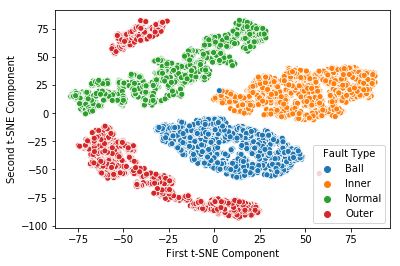

In [32]:
tsne_res = TSNE(n_components=2,random_state=4).fit_transform(outputs_test)
plt.figure()
sns.scatterplot(
        x=tsne_res[:,0], y= tsne_res[:,1],
        hue= fault_type,
        data=pd.DataFrame(tsne_res))
plt.legend(title = "Fault Type")
plt.xlabel("First t-SNE Component")
plt.ylabel("Second t-SNE Component")
plt.savefig("tsne_test_ims_iai.png", bbox_inches = "tight")

## Count number of nonzero activations

In [33]:
freq = np.zeros((16,))
for i in np.arange(2000):
    for j in range(16):
        if outputs_test[i,j] != 0:
            freq[j] = freq[j] + 1
freq

array([   0.,    0.,  355., 2000.,    0.,    0.,  129.,    0.,  167.,
        226., 2000.,  174.,  288.,  198.,   30.,    0.])

In [34]:
freq_1 = np.zeros((16,))
for i in np.arange(2000,4000):
    for j in range(16):
        if outputs_test[i,j] != 0:
            freq_1[j] = freq_1[j] + 1
freq_1

array([1.022e+03, 0.000e+00, 4.420e+02, 2.000e+03, 1.501e+03, 1.747e+03,
       0.000e+00, 0.000e+00, 3.000e+00, 9.650e+02, 2.750e+02, 1.973e+03,
       2.000e+03, 1.000e+00, 2.000e+03, 1.998e+03])

In [35]:
freq_2 = np.zeros((16,))
for i in np.arange(4000,6000):
    for j in range(16):
        if outputs_test[i,j] != 0:
            freq_2[j] = freq_2[j] + 1
freq_2

array([2000.,    0., 2000., 2000., 2000., 2000., 1995.,    0.,   42.,
       2000.,   33., 2000., 1980.,  172., 2000., 2000.])

In [36]:
freq_3 = np.zeros((16,))
for i in np.arange(6000,8000):
    for j in range(16):
        if outputs_test[i,j] != 0:
            freq_3[j] = freq_3[j] + 1
freq_3

array([1981.,    0., 2000., 2000.,  755., 1959., 1999.,    0., 2000.,
       2000., 2000., 2000.,  342., 1999., 1989., 1758.])

In [37]:
df_check = pd.DataFrame(data = {'freq':freq, 'freq_1':freq_1, 'freq_2':freq_2, 'freq_3':freq_3})

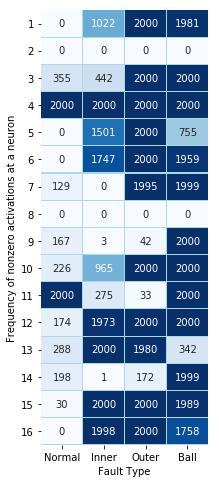

In [39]:
plt.figure(figsize = (3,8))
heatmap = sns.heatmap(df_check.to_numpy().astype(np.int32), cmap = "Blues", fmt = "d", annot = True, cbar = False,
                      xticklabels = ["Normal", "Inner", "Outer", "Ball"], yticklabels = np.arange(1,17),
                      linewidths = 0.1, linecolor = "lightblue")
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0)
heatmap.set(xlabel = "Fault Type", ylabel = "Frequency of nonzero activations at a neuron")
plt.savefig("activation_freq_ims_iai.png", bbox_inches = "tight")